In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

In [2]:
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"

In [3]:
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()

In [4]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

## Dynamics & stress-response characterization

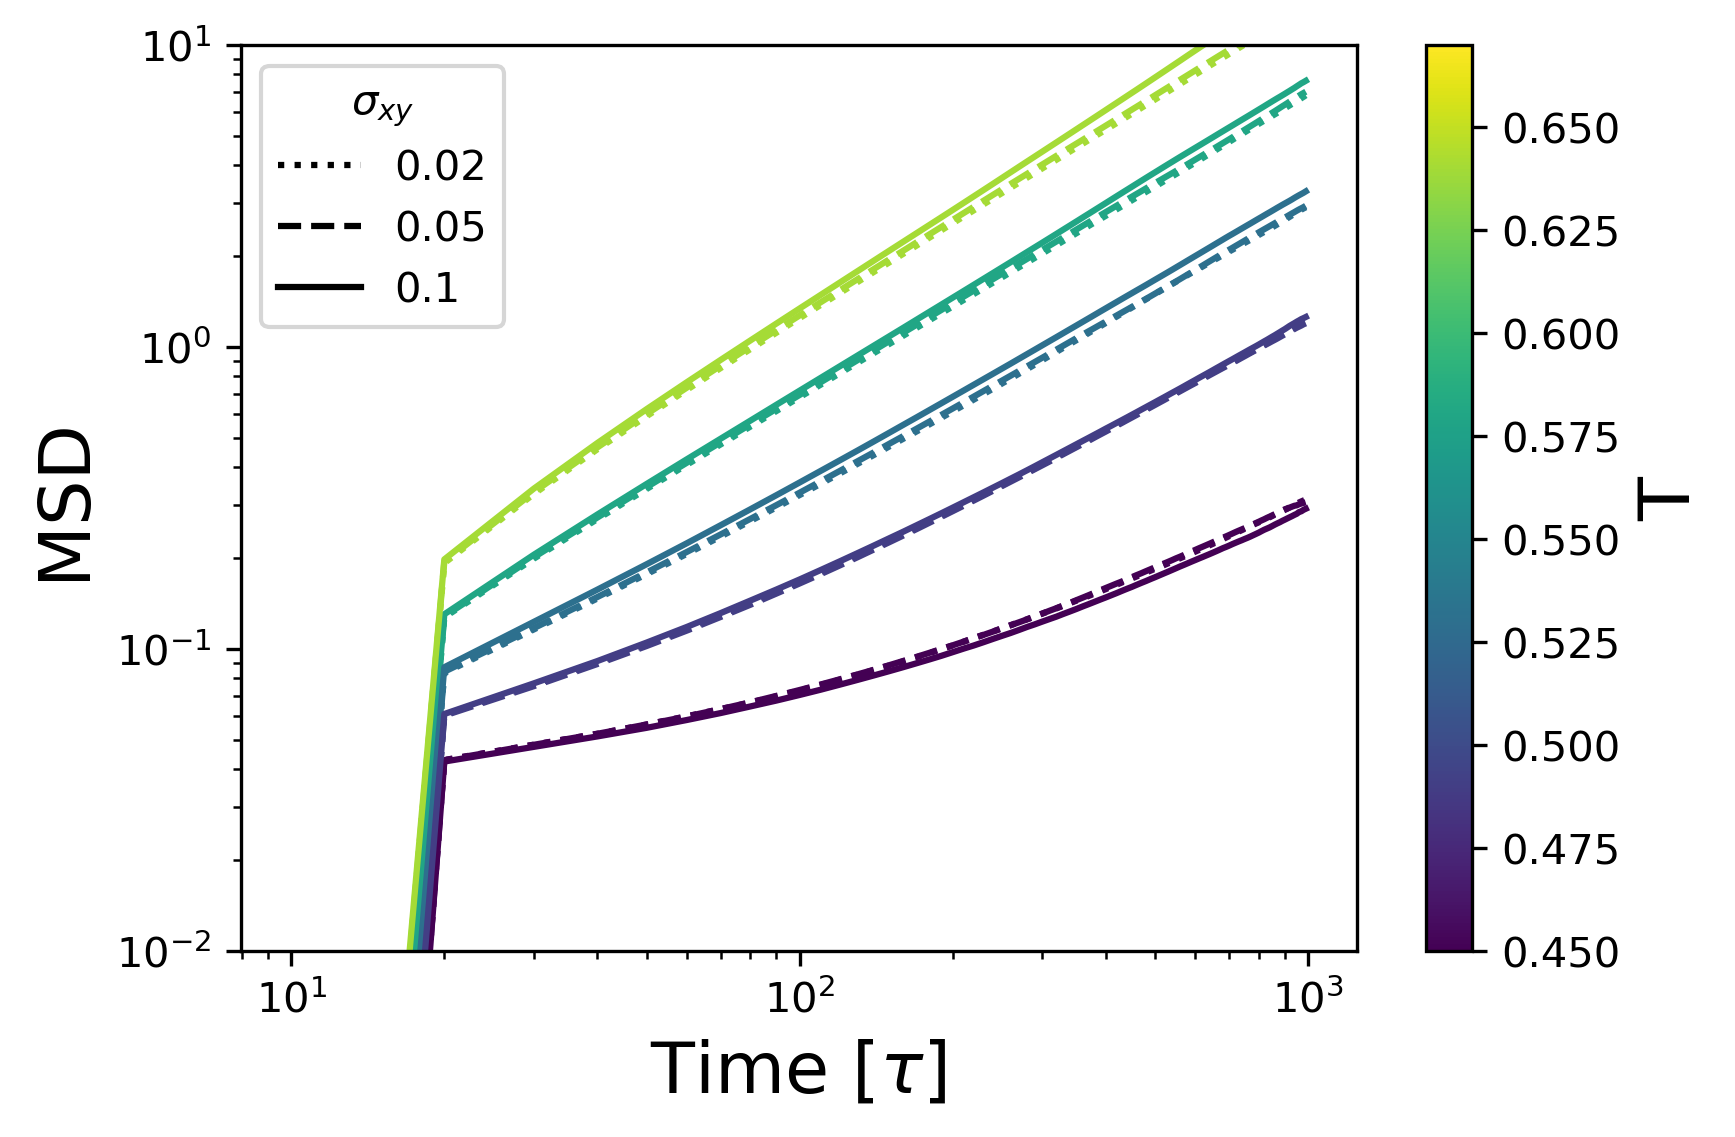

In [30]:
cmap = cm.viridis
norm = colors.Normalize(vmin=0.45, vmax=0.67)

ls = {0.02: ":", 0.05: "--", 0.1: "-"}

for idx, job in enumerate(project.find_jobs({"delta": 0.0, "replica": 0})):
    # print(idx, job.doc)
    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = glob.glob(job.fn("stress_runs/stress-*/temp-*/traj.gsd"))
    for run in runs:
        rate = float(utils.extract_between(run, "stress-", "/temp-"))
        temp = float(utils.extract_between(run, "temp-", "/traj.gsd"))
        # print(run)
        traj = gsd.hoomd.open(run, "rb")
        msd = freud.msd.MSD(mode="window")
        pos = []
        time = []
        step0 = traj[0].configuration.step
        box0 = freud.box.Box.from_box(traj[0].configuration.box)
        pos0 = box0.make_fractional(traj[0].particles.position)
        unit_box = freud.box.Box.cube(1)
        cube_box = freud.box.Box.cube(box0.Lx)
        prev = pos0
        image = np.zeros((len(traj[0].particles.position), 3), dtype=np.int32)
        for frame in traj[1:]:
            box = freud.box.Box.from_box(frame.configuration.box)
            new = box.make_fractional(frame.particles.position)
            image -= unit_box.get_images(new - prev)
            x = box.make_absolute(new)
            x = box.unwrap(x, image)
            x -= box.make_absolute(pos0)
            pos.append(x)
            time.append((frame.configuration.step - step0)*dt)
            prev = new
        msd.compute(pos, reset=True)
        plt.plot(time, msd.msd, color=cmap(norm(temp)), linestyle=ls[rate])

lines = []
lines.append(plt.Line2D([0], [0], color="black", linestyle=":"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="--"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="-"))

plt.ylabel("MSD")
plt.xlabel(r"Time [$\tau$]")
plt.legend(lines, ["0.02", "0.05", "0.1"], title=r"$\sigma_{xy}$")
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-2, 1e1)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")

In [28]:
def sisf(pos, k=7.14):

    term = k*np.linalg.norm(pos - pos[0], axis=-1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return np.mean(np.nan_to_num(np.sin(term)/term, nan=1.0), axis=1)

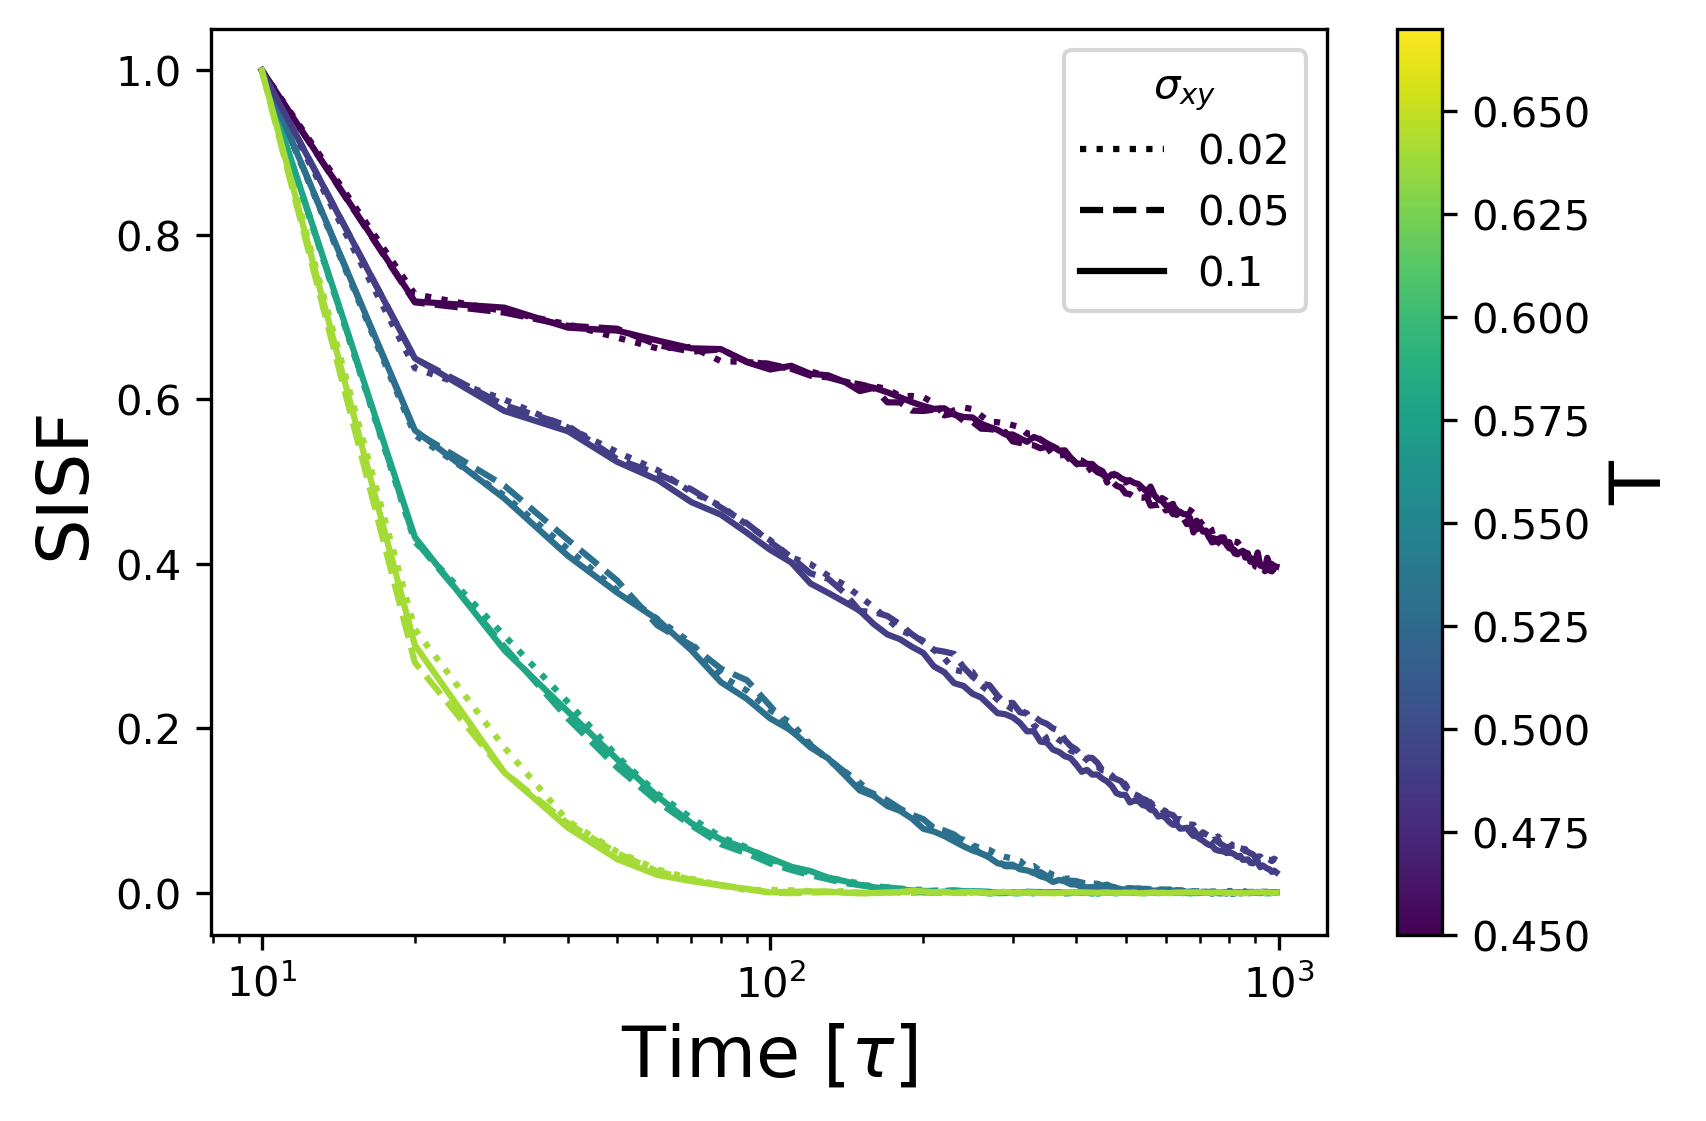

In [29]:
cmap = cm.viridis
norm = colors.Normalize(vmin=0.45, vmax=0.67)

ls = {0.02: ":", 0.05: "--", 0.1: "-"}

for idx, job in enumerate(project.find_jobs({"delta": 0.0, "replica": 0})):
    # print(idx, job.doc)
    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = glob.glob(job.fn("stress_runs/stress-*/temp-*/traj.gsd"))
    for run in runs:
        rate = float(utils.extract_between(run, "stress-", "/temp-"))
        temp = float(utils.extract_between(run, "temp-", "/traj.gsd"))
        # print(run)
        traj = gsd.hoomd.open(run, "rb")
        # msd = freud.msd.MSD(mode="window")
        pos = []
        time = []
        step0 = traj[0].configuration.step
        box0 = freud.box.Box.from_box(traj[0].configuration.box)
        pos0 = box0.make_fractional(traj[0].particles.position)
        unit_box = freud.box.Box.cube(1)
        cube_box = freud.box.Box.cube(box0.Lx)
        prev = pos0
        image = np.zeros((len(traj[0].particles.position), 3), dtype=np.int32)
        for frame in traj[1:]:
            box = freud.box.Box.from_box(frame.configuration.box)
            new = box.make_fractional(frame.particles.position)
            image -= unit_box.get_images(new - prev)
            x = box.make_absolute(new)
            x = box.unwrap(x, image)
            x -= box.make_absolute(pos0)
            pos.append(x)
            time.append((frame.configuration.step - step0)*dt)
            prev = new
        data = sisf(pos)
        plt.plot(time, data, color=cmap(norm(temp)), linestyle=ls[rate])

lines = []
lines.append(plt.Line2D([0], [0], color="black", linestyle=":"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="--"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="-"))

plt.ylabel("SISF")
plt.xlabel(r"Time [$\tau$]")
plt.legend(lines, ["0.02", "0.05", "0.1"], title=r"$\sigma_{xy}$")
# plt.yscale('log')
plt.xscale('log')
# plt.ylim(7e0, 1.5e2)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")

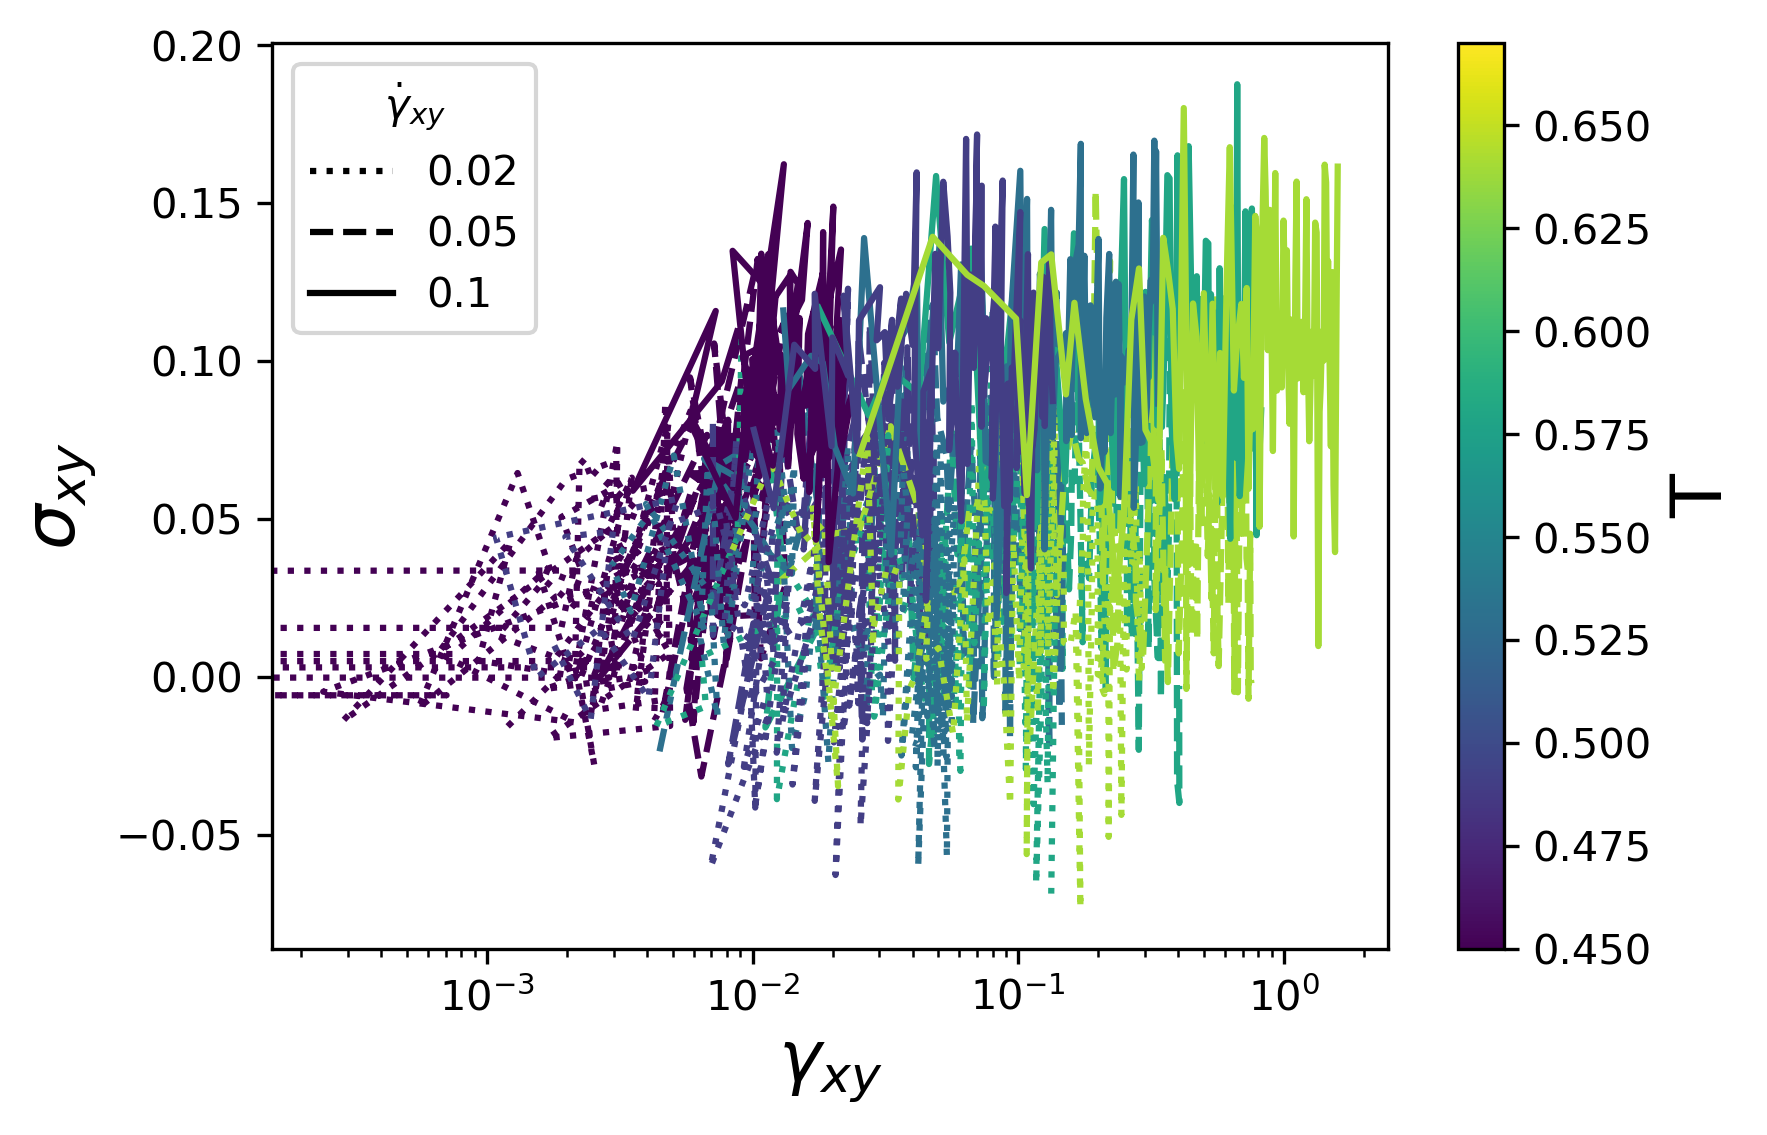

In [18]:
cmap = cm.viridis
norm = colors.Normalize(vmin=0.45, vmax=0.67)

ls = {0.02: ":", 0.05: "--", 0.1: "-"}


sr_temp_to_stress = {}

for idx, job in enumerate(project.find_jobs({"delta": 0.0, "replica": 0})):
    # print(idx, job.doc)
    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = glob.glob(job.fn("stress_runs/stress-*/temp-*/traj.gsd"))
    for run in runs:
        rate = float(utils.extract_between(run, "stress-", "/temp-"))
        temp = float(utils.extract_between(run, "temp-", "/traj.gsd"))
        # if temp != 0.49:
        #     continue
        # print(run)
        traj = gsd.hoomd.open(run, "rb")
        # msd = freud.msd.MSD(mode="window")
        pos = []
        time = []
        # step0 = traj[0].configuration.step
        # box0 = freud.box.Box.from_box(traj[0].configuration.box)
        # pos0 = box0.make_fractional(traj[0].particles.position)
        # unit_box = freud.box.Box.cube(1)
        # cube_box = freud.box.Box.cube(box0.Lx)
        # prev = pos0
        # image = np.zeros((len(traj[0].particles.position), 3), dtype=np.int32)
        for frame in traj:
            pos.append(frame.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1])
            time.append(-frame.log["box/xy"][0])
            # box = freud.box.Box.from_box(frame.configuration.box)
            # new = box.make_fractional(frame.particles.position)
            # image += unit_box.get_images(new - prev)
            # x = box.unwrap(new, image)
            # x -= box.make_absolute(pos0)
            # pos.append(x)
            # time.append((frame.configuration.step - step0)*dt)
            # prev = new
        # data = sisf(pos)
        stress_ave = []
        for frame in traj[-20:]:
            stress_ave.append(-frame.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1])
        stress_ave = np.mean(stress_ave)
        sr_temp_to_stress[(rate, temp)] = stress_ave

        plt.plot(time, pos, color=cmap(norm(temp)), linestyle=ls[rate])

lines = []
lines.append(plt.Line2D([0], [0], color="black", linestyle=":"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="--"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="-"))

plt.ylabel(r"$\sigma_{xy}$")
plt.xlabel(r"$\gamma_{xy}$")
plt.legend(lines, ["0.02", "0.05", "0.1"], title=r"$\dot{\gamma}_{xy}$")
# plt.yscale('log')
plt.xscale('log')
# plt.ylim(7e0, 1.5e2)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")

## Analysis of stress runs

Let's get the $D^2_{min}$ computation going, and compare that to affinely transformed $p_{hop}$

(0.05, 0.45)
(0.05, 0.58)
(0.05, 0.53)
(0.05, 0.49)
(0.05, 0.64)
(0.02, 0.45)
(0.02, 0.58)
(0.02, 0.53)
(0.02, 0.49)
(0.02, 0.64)
(0.1, 0.45)
(0.1, 0.58)
(0.1, 0.53)
(0.1, 0.49)
(0.1, 0.64)


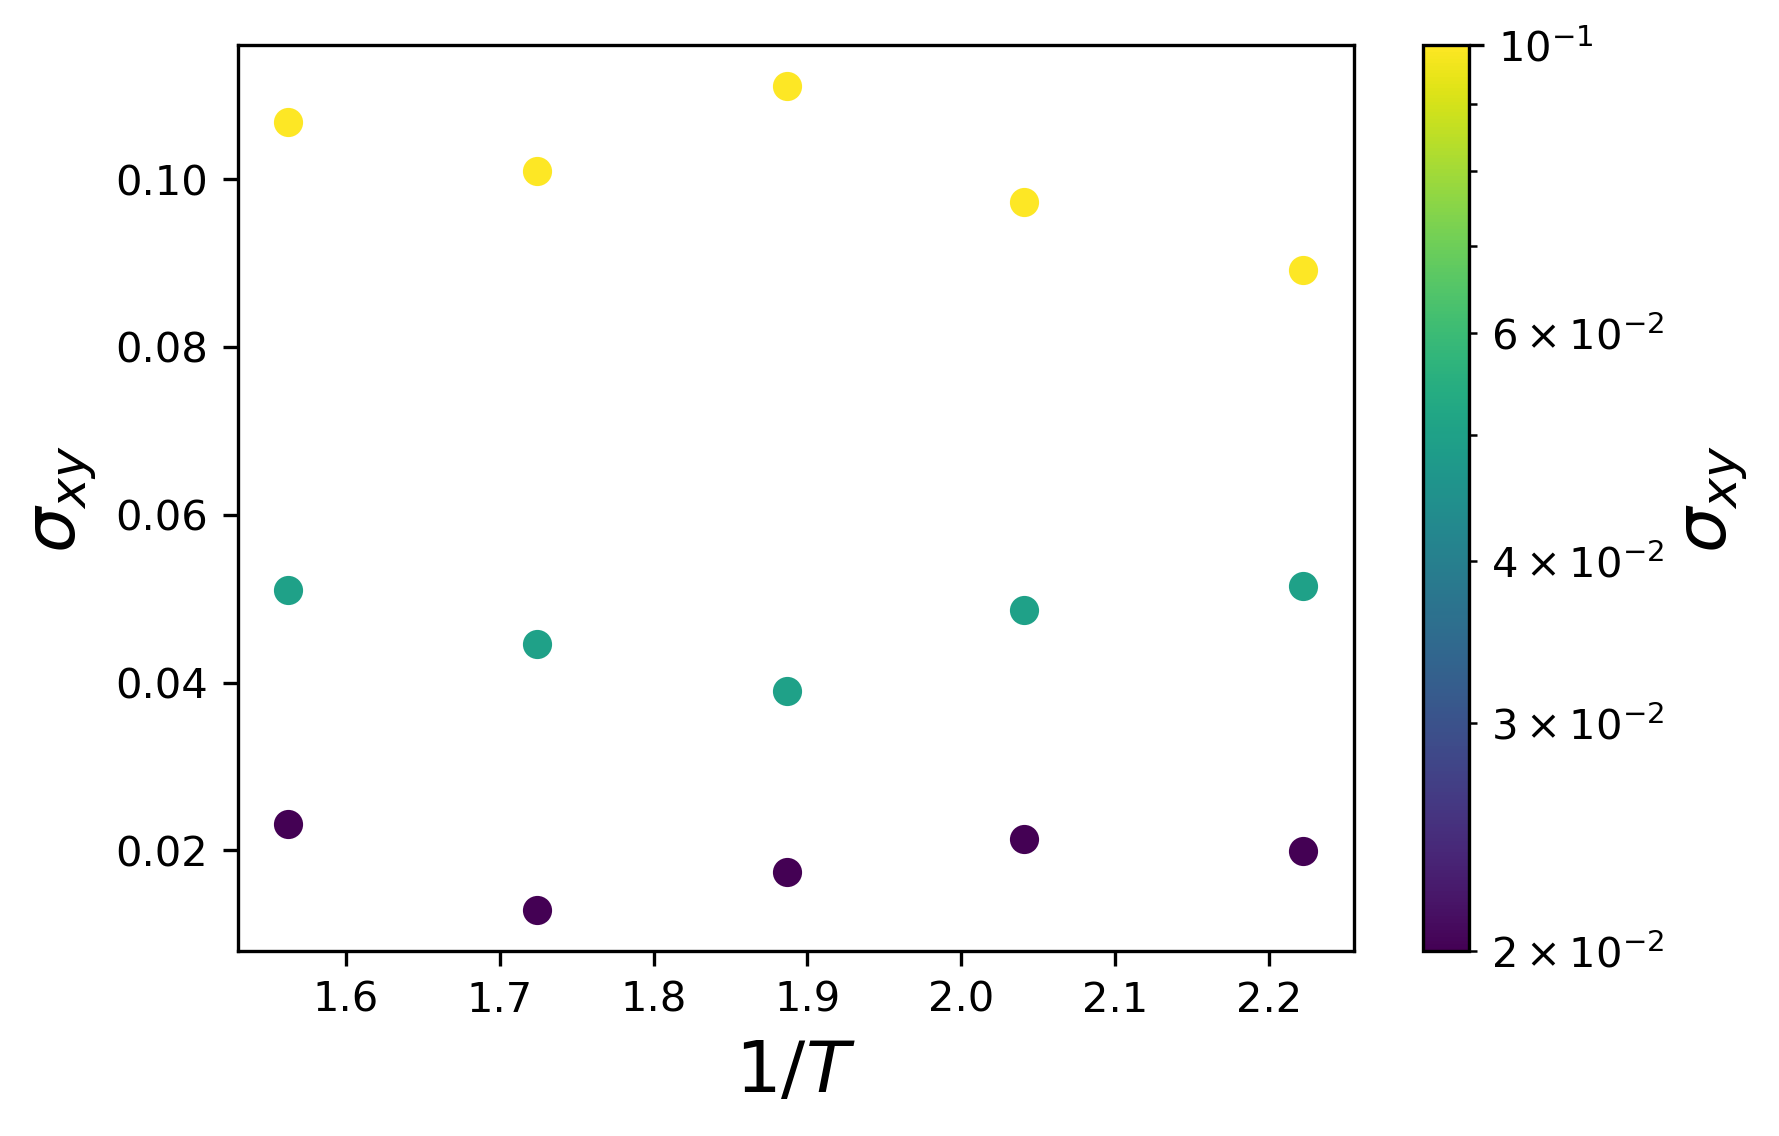

In [19]:
norm = colors.LogNorm(vmin=0.02, vmax=0.1)

for key, value in sr_temp_to_stress.items():
    print(key)
    plt.plot(1/key[1], -value, "o", color=cmap(norm(key[0])))

plt.ylabel(r"$\sigma_{xy}$")
plt.xlabel(r"$1/T$")
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\sigma_{xy}$")

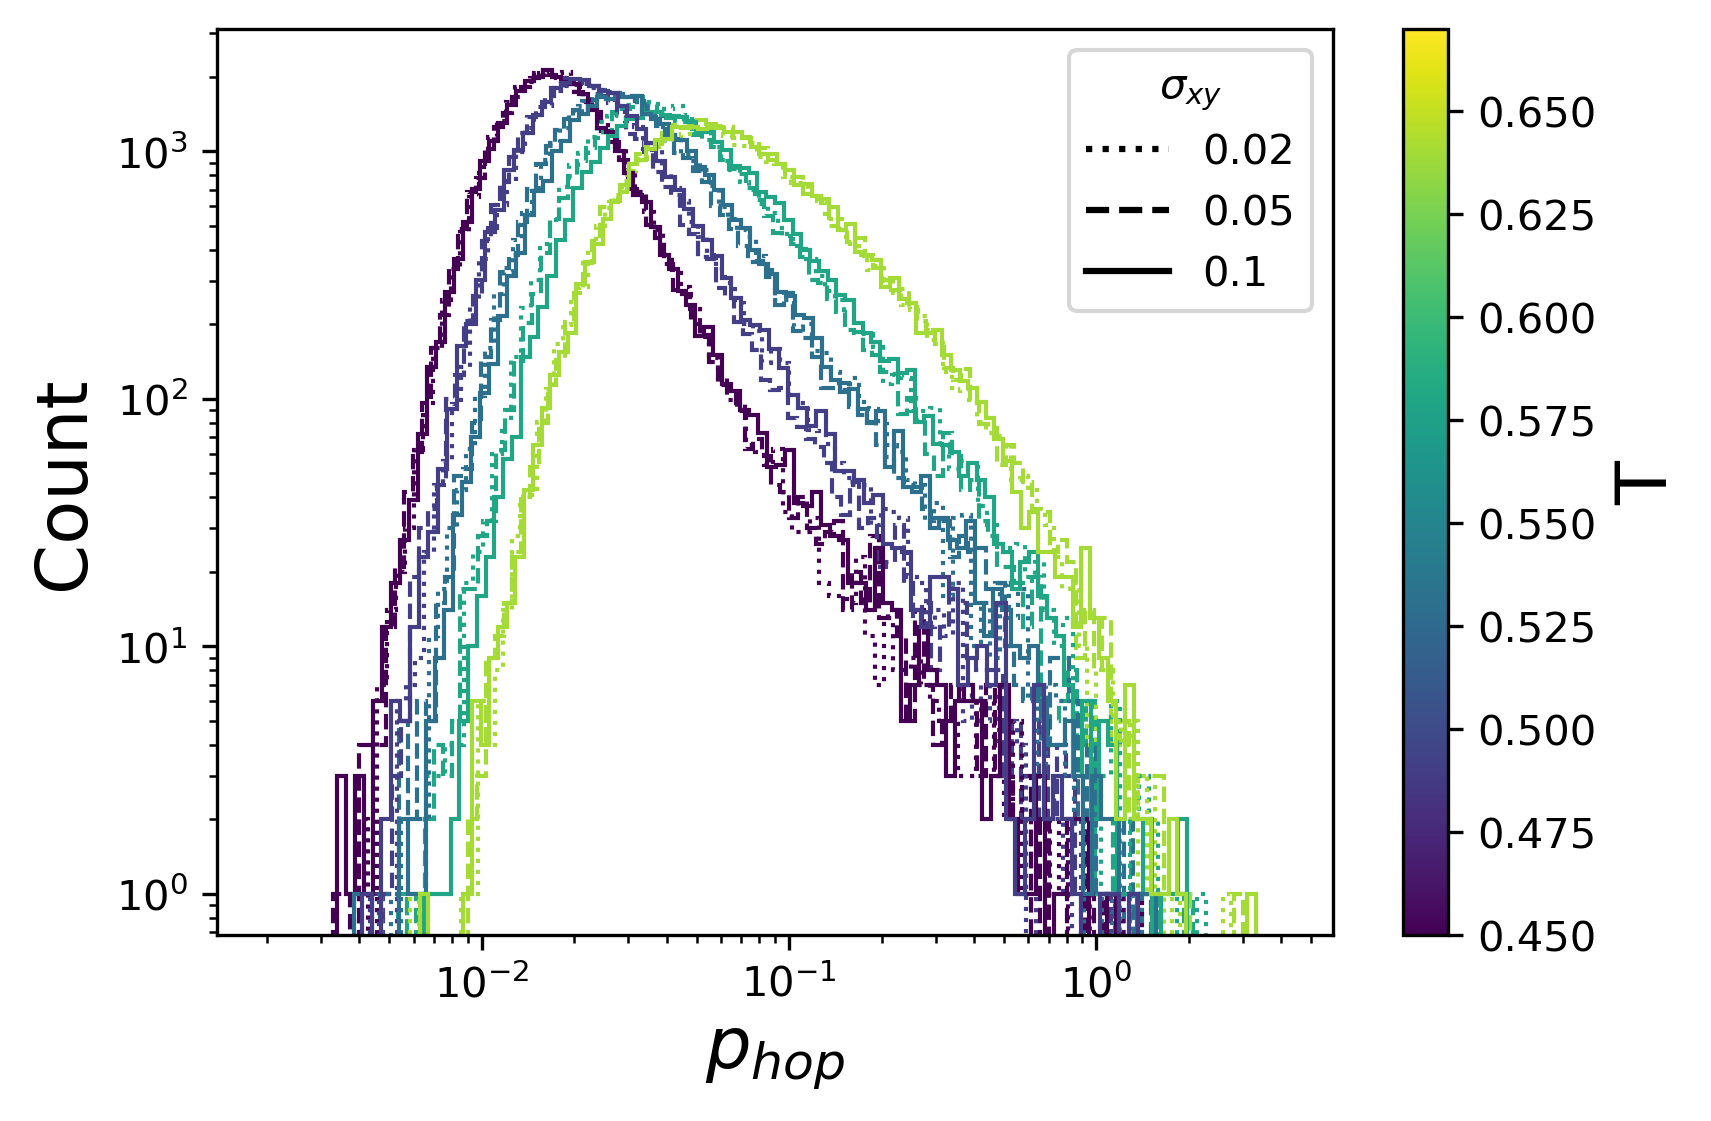

In [26]:
cmap = cm.viridis
norm = colors.Normalize(vmin=0.45, vmax=0.67)

ls = {0.02: ":", 0.05: "--", 0.1: "-"}

for idx, job in enumerate(project.find_jobs({"delta": 0.0, "replica": 0})):
    # print(idx, job.doc)
    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = glob.glob(job.fn("stress_runs/stress-*/temp-*/analysis_traj.gsd"))
    for run in runs:
        rate = float(utils.extract_between(run, "stress-", "/temp-"))
        temp = float(utils.extract_between(run, "temp-", "/analysis_traj.gsd"))
        # print(run)
        traj = gsd.hoomd.open(run, "rb")
        # msd = freud.msd.MSD(mode="window")
        pos = []
        time = []
        step0 = traj[0].configuration.step
        box0 = freud.box.Box.from_box(traj[0].configuration.box)
        pos0 = box0.make_fractional(traj[0].particles.position)
        unit_box = freud.box.Box.cube(1)
        cube_box = freud.box.Box.cube(box0.Lx)
        prev = pos0
        image = np.zeros((len(traj[0].particles.position), 3), dtype=np.int32)
        for frame in traj:
            box = freud.box.Box.from_box(frame.configuration.box)
            new = box.make_fractional(frame.particles.position)
            image -= unit_box.get_images(new - prev)
            x = box.make_absolute(new)
            x = box.unwrap(x, image)
            x -= box.make_absolute(pos0)
            pos.append(x)
            time.append((frame.configuration.step - step0)*dt)
            prev = new
        phop = schmeud_dynamics.p_hop(np.array(pos), 11)
        # plt.plot(time, pos, color=cmap(norm(temp)), linestyle=ls[rate])
        plt.hist(phop[0], bins=np.geomspace(np.min(phop), np.max(phop), 100), histtype="step", color=cmap(norm(temp)), linestyle=ls[rate])
        # break
    break

lines = []
lines.append(plt.Line2D([0], [0], color="black", linestyle=":"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="--"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="-"))

plt.xlabel(r'$p_{hop}$')
plt.ylabel("Count")
plt.legend(lines, ["0.02", "0.05", "0.1"], title=r"$\sigma_{xy}$")
plt.yscale('log')
plt.xscale('log')
# plt.ylim(7e0, 1.5e2)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")

## Compute softness using old hyperplanes

In [21]:
# grab a softness hyperplane

for job in project.find_jobs({"delta": 0.0, "replica": 0}, {"_CRYSTAL": {"$exists": False}}):

    delta = 0.0

    print(delta)
    
    temps = job.doc["temps"]

    with open(project.fn(f"softness_pipelines/delta-{delta:.1f}/pipe_ss-0_ts-10.pickle"), "rb") as f:
        pipeline = pickle.load(f)
    pipe = pipeline["pipe"]

    print(pipe)

    # loop over systems

    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = glob.glob(job.fn("stress_runs/stress-*/temp-*/sfs.parquet"))
    for run in runs:
        print(run)
        df = pd.read_parquet(run)
        df = df[df["type"] == 0]

        df["softness"] = pipe.decision_function(list(df["sf"]))

        df["rearrang"] = df["phop"] > 0.2

        df.drop('sf', axis=1, inplace=True)
        
        out_file = run.replace("sfs.parquet", "struct-descr.parquet")
        assert out_file != run
        df.to_parquet(out_file)

0.0
Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(class_weight='balanced', max_iter=10000,
                           random_state=4105996076))])
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/stress_runs/stress-0.05/temp-0.45/sfs.parquet
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/stress_runs/stress-0.05/temp-0.58/sfs.parquet
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/stress_runs/stress-0.05/temp-0.53/sfs.parquet
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/stress_runs/stress-0.05/temp-0.49/sfs.parquet
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/stress_runs/stress-0.05/temp-0.64/sfs.parquet
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/stress_runs/stress-0.02/temp-0.45/sfs.parquet
/media/ian/Data2/monk/mlj-production/workspace/

In [22]:
# grab a softness hyperplane

for job in project.find_jobs({"delta": 0.0, "replica": 0}, {"_CRYSTAL": {"$exists": False}}):

    delta = 0.0

    print(delta)
    
    temps = job.doc["temps"]

    with open(project.fn(f"softness_pipelines/delta-{delta:.1f}/pipe_ss-0_ts-10.pickle"), "rb") as f:
        pipeline = pickle.load(f)
    pipe = pipeline["pipe"]

    print(pipe)

    # loop over systems

    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = glob.glob(job.fn("stress_runs/stress-*/temp-*/struct-descr.parquet"))  # read
    rearrang_file = project.fn(f"prob_rearrang/stress_softness_delta-{delta}.pickle")  # write
    bounds_file_pkl = project.fn(f"structure/softness-bounds_delta-{delta}.pickle")  # read
    softness_bounds = pickle.load(open(bounds_file_pkl, "rb"))
    be = np.linspace(softness_bounds["min"], softness_bounds["max"], 6)
    soft_bin_centers = be[:-1] + np.diff(be)/2

    plot_data = []
    temps = []
    stresses = []

    for run in runs:
        temp = float(utils.extract_between(run, "temp-", "/"))
        stress = float(utils.extract_between(run, "stress-", "/"))
        print(run, temp, stress)
        df = pd.read_parquet(run)
        df = df[df["type"] == 0]

        df["cuts"] = pd.cut(df["softness"], bins=be)

        data = []
        for cut, df_cut in df.groupby("cuts"):
            data.append([cut.mid, df_cut["rearrang"].mean()])
        plot_data.append(data)
        temps.append(temp)
        stresses.append(stress)
    plot_data = np.array(plot_data)

    output_data = dict(delta=delta, temps=temps, bounds_data=softness_bounds, data=plot_data, bin_centers=soft_bin_centers, bin_edges=be, stresses=stresses)

    pickle.dump(output_data, open(rearrang_file, "wb"))

0.0
Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(class_weight='balanced', max_iter=10000,
                           random_state=4105996076))])
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/stress_runs/stress-0.05/temp-0.45/struct-descr.parquet 0.45 0.05
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/stress_runs/stress-0.05/temp-0.58/struct-descr.parquet 0.58 0.05
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/stress_runs/stress-0.05/temp-0.53/struct-descr.parquet 0.53 0.05
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/stress_runs/stress-0.05/temp-0.49/struct-descr.parquet 0.49 0.05
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/stress_runs/stress-0.05/temp-0.64/struct-descr.parquet 0.64 0.05
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc99

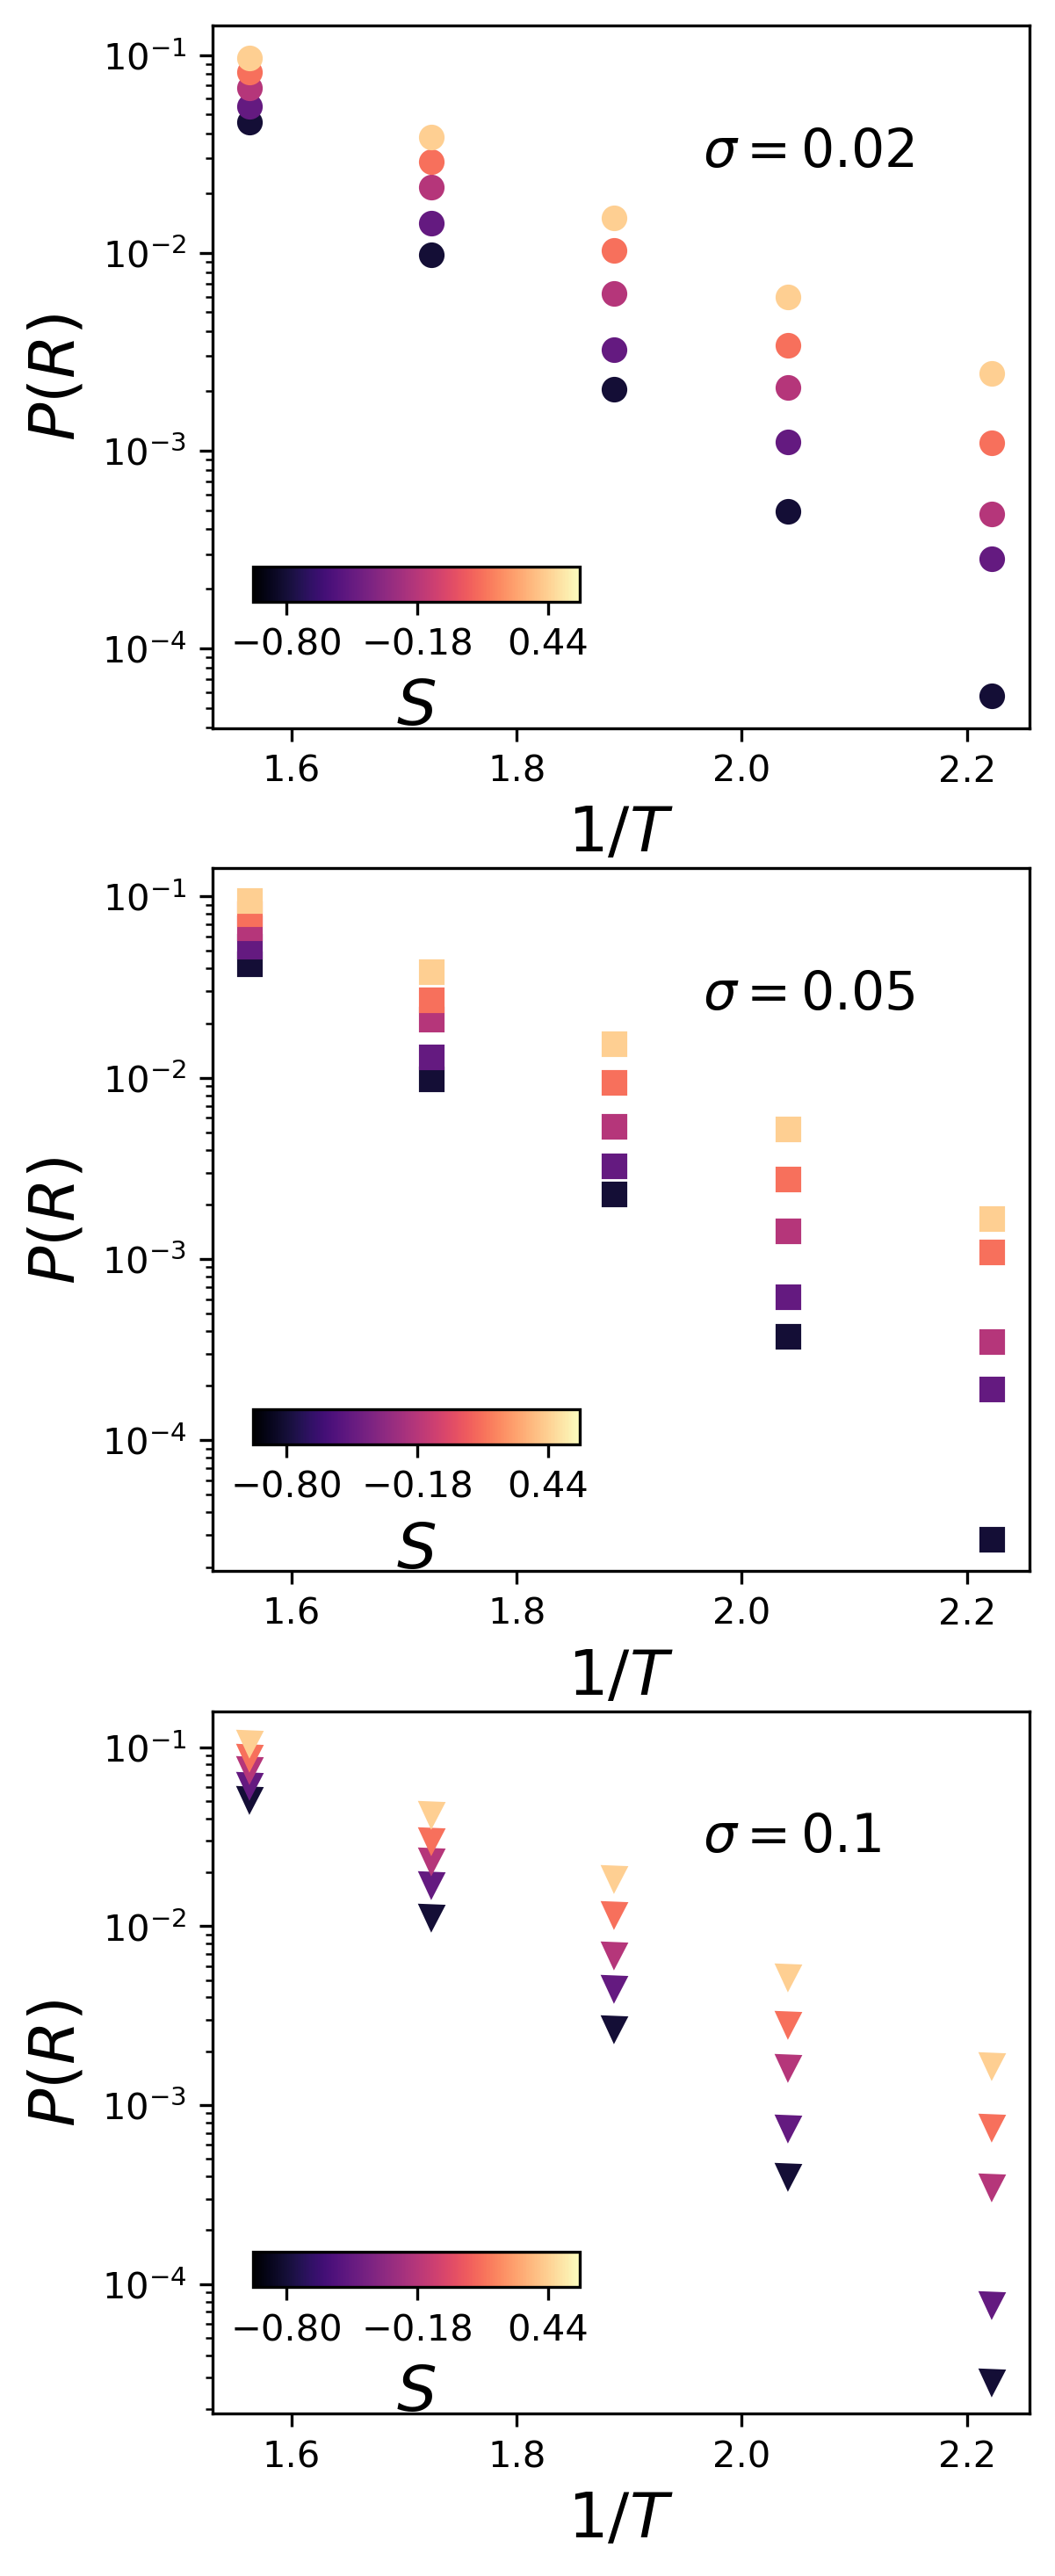

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(4, 12))

rate_markers = {0.02: "o", 0.05: "s", 0.1: "v"}
axs_dict = {0.02: axs[0], 0.05: axs[1], 0.1: axs[2]}
rate_dict = {axs[0]: 0.02, axs[1]: 0.05, axs[2]: 0.1}

for job in project.find_jobs({"delta": 0.0, "replica": 0}, {"_CRYSTAL": {"$exists": False}}):

    delta = 0.0

    file = project.fn(f"prob_rearrang/stress_softness_delta-{delta}.pickle")
    data = pickle.load(open(file, "rb"))
    bd = data["bounds_data"]
    # cmap = sns.color_palette("flare", as_cmap=True)
    cmap = sns.color_palette("magma", as_cmap=True)
    norm = colors.Normalize(bd["min"], bd["max"])
    itemps = []

    for temp, soft, stress in zip(data["temps"], data["data"], data["stresses"]):
        itemps.append(1/temp)

        for s, d in soft:
            plt.sca(axs_dict[stress])
            plt.plot(1/temp, d, rate_markers[stress], color=cmap(norm(s)))

    # for d, s in zip(data["data"][11:,:,1].T, data["data"][11:,:,0].T):
    #     p = np.polyfit(itemps, np.log(d), 1)
    #     x = np.linspace(itemps[0], itemps[-1], 100)
    #     y = np.polyval(p, x)
    #     plt.plot(x, np.exp(y), color=cmap(norm(s[0])), alpha=0.5)
    
for ax in axs:
    plt.sca(ax)
    plt.yscale('log')
    cbaxes = ax.inset_axes([0.05, 0.18, 0.4, 0.05])
    sm = cm.ScalarMappable(norm, cmap)
    ticks = np.around(soft[::2,0], 2)
    plt.colorbar(sm, ticks=ticks, cax=cbaxes, label=r"$S$", orientation='horizontal')
    plt.text(0.6, 0.8, rf'$\sigma={rate_dict[ax]}$', transform=ax.transAxes, size="x-large")
    plt.ylabel(r"$P(R)$", size="xx-large")
    plt.xlabel(r"$1/T$", size="xx-large")


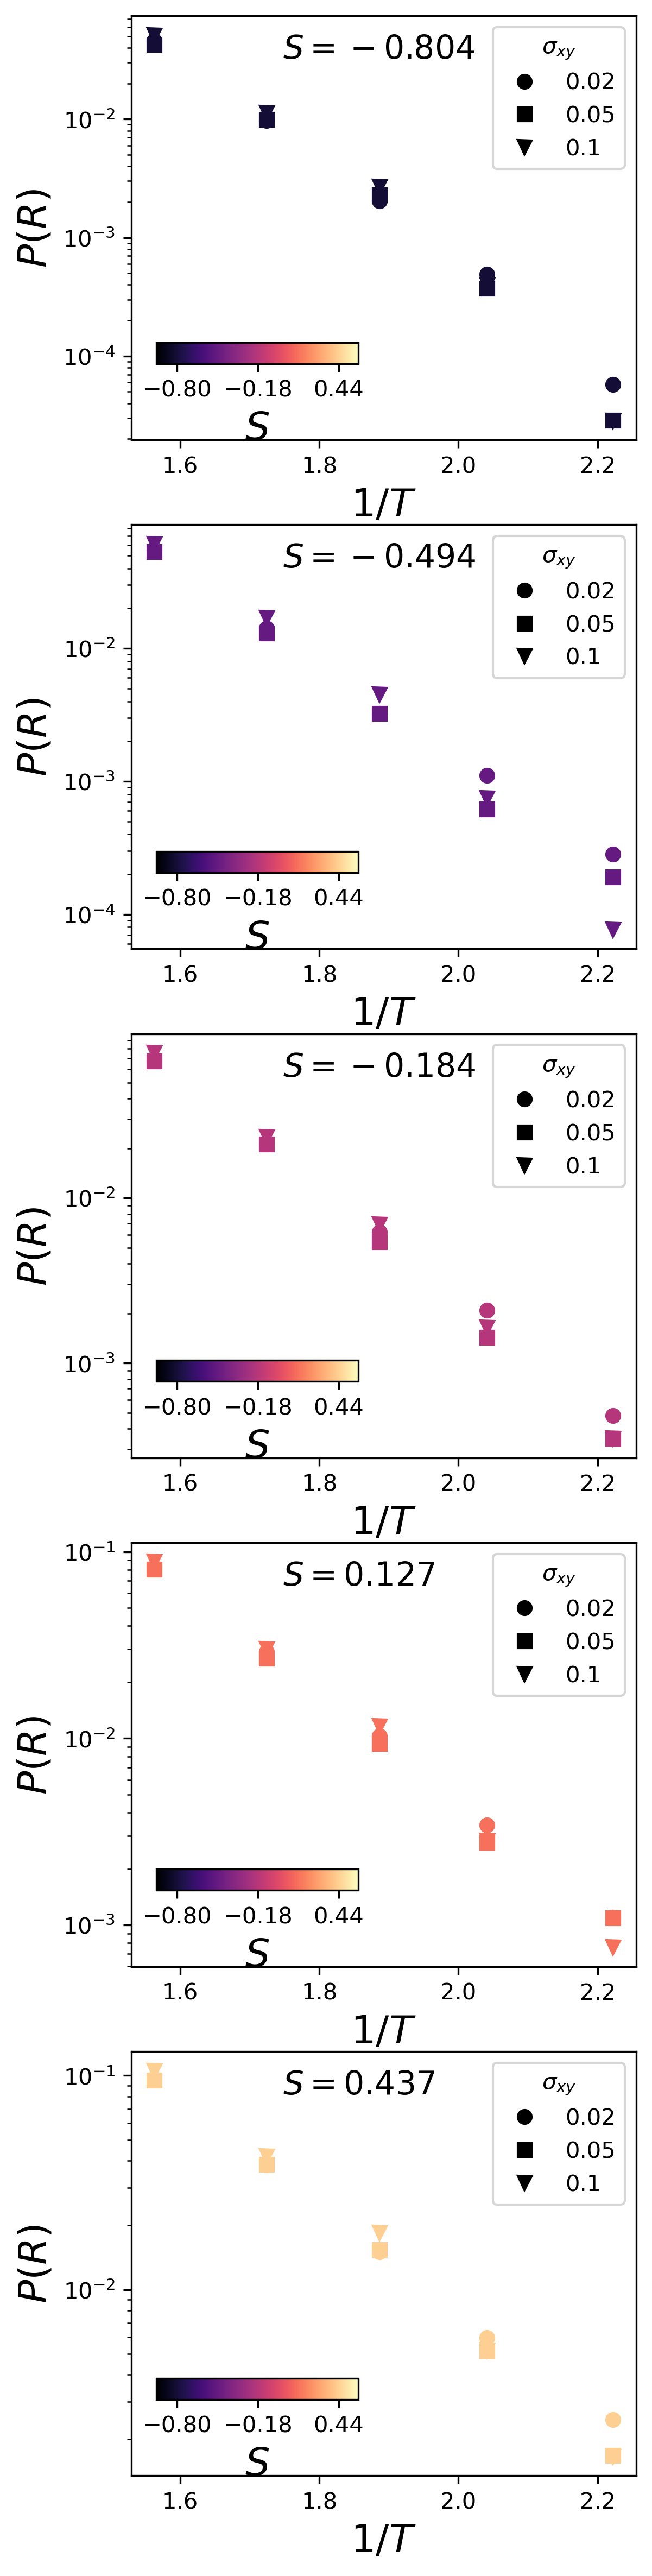

In [25]:
fig, axs = plt.subplots(5, 1, figsize=(4, 20))

rate_markers = {0.02: "o", 0.05: "s", 0.1: "v"}

# soft = np.array([[-0.804     ,  0.04062084],
#        [-0.494     ,  0.05164118],
#        [-0.18375   ,  0.06483949],
#        [ 0.12675   ,  0.07920901],
#        [ 0.437     ,  0.09488894]])

soft_dict = {}
ax_dict = {}
for point, ax in zip(soft[:,0], axs):
    soft_dict[point] = ax
    ax_dict[ax] = point

for ax in axs:
    plt.sca(ax)
    lines = []
    lines.append(plt.Line2D([0], [0], color="black", linestyle="", marker="o"))
    lines.append(plt.Line2D([0], [0], color="black", linestyle="", marker="s"))
    lines.append(plt.Line2D([0], [0], color="black", linestyle="", marker="v"))

    plt.legend(lines, ["0.02", "0.05", "0.1"], title=r"$\sigma_{xy}$")
    plt.yscale('log')
    cbaxes = ax.inset_axes([0.05, 0.18, 0.4, 0.05])
    sm = cm.ScalarMappable(norm, cmap)
    ticks = np.around(soft[::2,0], 2)
    plt.colorbar(sm, ticks=ticks, cax=cbaxes, label=r"$S$", orientation='horizontal')
    plt.text(0.3, 0.9, rf'$S={ax_dict[ax]:.3}$', transform=ax.transAxes, size="x-large")
    plt.ylabel(r"$P(R)$", size="xx-large")
    plt.xlabel(r"$1/T$", size="xx-large")


for job in project.find_jobs({"delta": 0.0, "replica": 0}, {"_CRYSTAL": {"$exists": False}}):

    delta = 0.0

    file = project.fn(f"prob_rearrang/stress_softness_delta-{delta}.pickle")
    data = pickle.load(open(file, "rb"))
    bd = data["bounds_data"]
    # cmap = sns.color_palette("flare", as_cmap=True)
    cmap = sns.color_palette("magma", as_cmap=True)
    norm = colors.Normalize(bd["min"], bd["max"])
    itemps = []

    for temp, soft, stress in zip(data["temps"], data["data"], data["stresses"]):
        itemps.append(1/temp)

        for s, d in soft:
            plt.sca(soft_dict[s])
            plt.plot(1/temp, d, rate_markers[stress], color=cmap(norm(s)))

### Extract fit parameters from probability of rearrangement curves

In [ ]:

for job in project.find_jobs({"delta": 0.0, "replica": 0}, {"_CRYSTAL": {"$exists": False}}):

    delta = 0.0

    file = project.fn(f"prob_rearrang/shear_softness_delta-{delta}.pickle")
    data = pickle.load(open(file, "rb"))
    bd = data["bounds_data"]
    # cmap = sns.color_palette("flare", as_cmap=True)
    cmap = sns.color_palette("magma", as_cmap=True)
    norm = colors.Normalize(bd["min"], bd["max"])
    itemps = []
    data = []

    for temp, soft, shear_rate in zip(data["temps"], data["data"], data["shear_rates"]):
        itemps.append(1/temp)
        for s, d in soft:
            # plt.sca(soft_dict[s])
            # plt.plot(1/temp, d, rate_markers[shear_rate], color=cmap(norm(s)))

    fit_data = {}
    inv_t = np.array(itemps)
    for d, s in zip(data["data"][11:,:,1].T, data["data"][11:,:,0].T):
        p = np.polyfit(itemps, np.log(d), 1)
        x = np.linspace(itemps[0], itemps[-1], 100)
        y = np.polyval(p, x)
        fit_data[s[0]] = dict(x=x, y=y, p=p, d=d, log_d=np.log(d))